# Project 4: NLP - Sentiment Analysis
 Jamaal Smith<br>
 Flatiron School <br>
 [Video Walkthrough of PowerPoint](https://www.youtube.com/channel/UCoq5xP_nSnfo-GxediakXUQ/videos?view=0&sort=dd&shelf_id=0).

## Introduction

Sentiment Analysis is a useful tool within the Natural Language Processing domain that enables organizations to get a sense how the public is responding to their brand. In this analysis, I will perform such an analysis on a set of tweets from [data.world.](https://data.world/crowdflower/brands-and-product-emotions).

Through analysis of these tweets, I hope to learn the context with which Apple and Google are being compared in these tweets. By this, are these tweets all from a single point in time such as a product release. I also believe analysis of the tweets can provide context as to the tweet's audience base. Finally, this analysis can also provide useful insights into how the brand with lesser social media on clout might be able to revamp their image to drive the sort of customer engagement that they desire.

# Obtaining Data

In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
sns.set_context('talk')

In [2]:
data = pd.read_csv('data.csv',encoding='utf-8')
data = data.astype(str)
tweets = pd.DataFrame(data['tweet_text'])

## Scrubbing/Cleaning Data

### DataFrame treatment

In [3]:
#preview of data
data.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,nan,No emotion toward brand or product
6,nan,nan,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [4]:
#stats on data
data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9288,9288,9288
unique,9168,10,5
top,nan,nan,No emotion toward brand or product
freq,27,5997,5389


In [5]:
# Dropping NANs
indexNames = data[data['emotion_in_tweet_is_directed_at'] == 'nan' ].index
# Delete these row indexes from dataFrame
data.drop(indexNames , inplace=True)

data.dropna()


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9272,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion
9274,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion
9275,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion
9280,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion


In [6]:
#Renaming of columns
data=data.rename(columns={'emotion_in_tweet_is_directed_at':'Brand','is_there_an_emotion_directed_at_a_brand_or_product':'Sentiment'})

In [7]:
#Changing column info to assist with encoding later
product_dict = {"iPhone":'Apple','iPad or iPhone App': 'Apple','iPad':'Apple','nan':'none','Android':'Google','Android App':'Google','Other Google product or service':'Google','Other Apple product or service':'Apple'}
sentiment_dict = {'Negative emotion': '1','Positive emotion':'2','No emotion toward brand or product':'0', "I can't tell": '0'}
data = data.replace({"Brand": product_dict})
data = data.replace({'Sentiment':sentiment_dict})

#data['prediction'] = (data['Brand'],data['Sentiment'])
#data['prediction'] = list(zip(data.Brand, data.Sentiment))
print(len(data['Brand']))
print(len(data['Sentiment']))

3291
3291


In [8]:
#from textblob import textblob
#data['polarity'] = data['tweet_text'].map(lambda text: TextBlob(text).sentiment.polarity)
data['review_len'] = data['tweet_text'].astype(str).apply(len)
data['word_count'] = data['tweet_text'].apply(lambda x: len(str(x).split()))

In [9]:
#stats without nan in tweet column
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3291 entries, 0 to 9283
Data columns (total 5 columns):
tweet_text    3291 non-null object
Brand         3291 non-null object
Sentiment     3291 non-null object
review_len    3291 non-null int64
word_count    3291 non-null int64
dtypes: int64(2), object(3)
memory usage: 154.3+ KB


In [10]:
#from sklearn.preprocessing import OneHotEncoder
#brands = data.Brand.as_matrix(columns=None)
#brands = brands.reshape(-1,1)
#oe = OneHotEncoder()
#data['Brand_code']= oe.fit_transform(brands)

In [11]:
data.head()

,tweet_text,Brand,Sentiment,review_len,word_count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,1,127,23
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,2,139,22
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,2,79,15
3,@sxsw I hope this year's festival isn't as cra...,Apple,1,82,15
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,2,131,17


### Twitter data

In [12]:
data.head(10) #preview of what data looks like
tweets = data['tweet_text']
len(tweets)

3291

In [13]:
import re
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
twitter_list = ['mention','rt','link','sxsw','quot','downtown','austin']
stopword_list = stopwords.words('english')
stopword_list = stopword_list + twitter_list
for tweet in tweets:
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)
    tweet = tweet.join([c for c in tweet if c not in punctuation])
    tweet = tweet.lower()
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [word for word in tweet if not word in stopword_list]
    tweet = ' '.join(tweet)
    corpus.append(tweet)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamaalsmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
data['tweet_text'] = corpus #so that dataframe has cleaned tweets

NameError: name 'Corpus' is not defined

In [15]:
##Tokenize data and then generate FreqDist
from nltk import word_tokenize
tokens = word_tokenize(','.join(map(str,corpus)))

In [16]:
#FreqDist
from nltk import FreqDist
freq = FreqDist(tokens)
most_used_words = freq.most_common(500)
most_used_words = pd.DataFrame(most_used_words, columns=['word','count'])
most_used_words.reset_index(drop=True,inplace=True)


## Exploratory Data Analysis

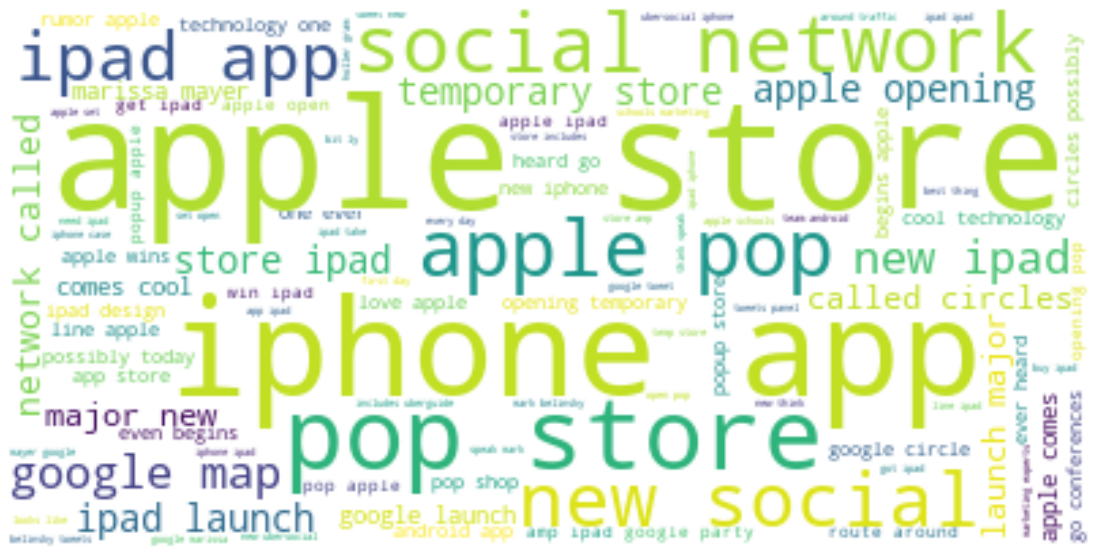

In [19]:
#Wordcloud of popular words
text = " ".join(tweet for tweet in corpus)
plt.figure(figsize=(35,10))
# Create stopword list:
stopwords = stopword_list

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
import scattertext as st
import spacy

#Data
nlp = st.WhitespaceNLP.whitespace_nlp
corpus = st.CorpusFromPandas(data,category_col= 'Brand', text_col='tweet_text',nlp=nlp).build()

#html = st.produce_scattertext_explorer(corpus,
                                       #category='positive emotion',
                                       #category_name='Positive emotion',
                                       #not_category_name='Negative emotion',
                                       #use_full_doc=True,
                                       #minimum_term_frequency=5,
                                       #pmi_filter_thresold=10,
                                       #term_ranker=st.OncePerDocFrequencyRanker,
                                       #width_in_pixels=1000,
                                       #sort_by_dist=False,
                                       #metadata=data['tweet_text'])

In [22]:
all_neg_words_df = data.loc[data['Sentiment'] == 'Negative']
all_pos_words_df = data.loc[data['Sentiment'] == 'Positive']
data['parsed'] = data['tweet_text'].apply(nlp)

In [23]:
#Common Negative Words
term_freq_neg_df = corpus.get_term_freq_df()
term_freq_neg_df['Negative Emotion'] = corpus.get_scaled_f_scores('Negative emotion')
print(list(term_freq_neg_df.sort_values(by='Negative Emotion', ascending=False).index[:20]))


Exception: Invalid category: Negative emotion, valid: ['Apple', 'Google']

In [ ]:
#Common Positive Words
term_freq_pos_df = corpus.get_term_freq_df()
term_freq_pos_df['Positive Emotion'] = corpus.get_scaled_f_scores('Positive emotion')
print(list(term_freq_df.sort_values(by='Positive Emotion', ascending=False).index[:20]))


In [ ]:
#Apple Words

#Positive Words
term_freq_apple_pos_df = positive.get_term_freq_df()
term_freq_apple_pos_df['Apple'] = corpus_pos.get_scaled_f_scores('Apple')
print(list(term_freq_apple_df.sort_values(by='Apple', ascending=False).index[:20]))


In [ ]:
#Top words associated with Apple
term_freq_df = corpus.get_term_freq_df() 
term_freq_df['Brand'] = corpus.get_scaled_f_scores('Apple')
pprint(list(term_freq_df.sort_values(by='Brand', ascending=False).index[:10]))

In [ ]:
from spacy.util import get_lang_class
nlp = get_lang_class('en')

In [ ]:
data.head()

In [ ]:
#Sentiment Analysis - Positive Popular Words
all_pos_words_df = data.loc[data['Sentiment'] == '2']
corpus_allpos = all_pos_words_df['tweet_text']

##Tokenize data and then generate FreqDist
from nltk import word_tokenize
tokens_pos = word_tokenize(','.join(map(str,corpus_allpos)))

#FreqDist
#from nltk import FreqDist
#freq_pos = FreqDist(tokens_pos)
#most_used_words_pos = freq_pos.most_common(100)
#most_used_words_pos = pd.DataFrame(most_used_words_pos, columns=['word','count'])
#most_used_words_pos.reset_index(drop=True,inplace=True)

#Wordcloud of popular words
text_pos = " ".join(tweet for tweet in corpus)
plt.figure(figsize=(35,10))
# Create stopword list:
stopwords = stopword_list

# Generate a word cloud image
wordcloud_pos = WordCloud(background_color="black").generate(text_pos)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
#Sentiment Analysis - Negative Popular Words
all_neg_words_df = data.loc[data['Sentiment'] == '1']
corpus_allneg = all_neg_words_df['tweet_text']

##Tokenize data and then generate FreqDist
from nltk import word_tokenize
tokens_neg = word_tokenize(','.join(map(str,corpus_allneg)))

#FreqDist
#from nltk import FreqDist
#freq_neg = FreqDist(tokens_neg)
#most_used_words_neg = freq_neg.most_common(100)
#most_used_words_neg = pd.DataFrame(most_used_words_neg, columns=['word','count'])
#most_used_words_neg.reset_index(drop=True,inplace=True)

#Wordcloud of popular words
text_neg = " ".join(tweet for tweet in corpus_allneg)
plt.figure(figsize=(35,10))
# Create stopword list:
stopwords = stopword_list

# Generate a word cloud image
wordcloud_neg = WordCloud(background_color="black").generate(text_neg)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
#Sentiment Analysis - Neutral Popular Words
#all_neutral_words_df =  data.loc[data['Sentiment'] == '0']
#corpus_allneu = all_neutral_words_df['tweet_text']

In [ ]:
#Sentiment Analysis - Positive Apple Words
appl_pos_words = data.loc[(data['Sentiment'] == '2') & (data['Brand'] == "Apple")]
corpus_applepos = appl_pos_words['tweet_text']

##Tokenize data and then generate FreqDist
from nltk import word_tokenize
tokens_applepos = word_tokenize(','.join(map(str,corpus_applepos)))

#FreqDist
#from nltk import FreqDist
#freq_applepos = FreqDist(tokens_applepos)
#most_used_words_applepos = freq_applepos.most_common(100)
#most_used_words_applepos = pd.DataFrame(most_used_words_applepos, columns=['word','count'])
#most_used_words_applepos.reset_index(drop=True,inplace=True)

#Wordcloud of popular words
text_applepos = " ".join(tweet for tweet in corpus_applepos)
plt.figure(figsize=(35,10))
# Create stopword list:
stopwords = stopword_list

# Generate a word cloud image
wordcloud_applepos = WordCloud(background_color="black").generate(text_applepos)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_applepos, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Sentiment Analysis - Negative Apple Words
appl_neg_words = data.loc[(data['Sentiment'] == '1') & (data['Brand'] == "Apple")]
corpus_appleneg = appl_neg_words['tweet_text']

##Tokenize data and then generate FreqDist
from nltk import word_tokenize
tokens_appleneg = word_tokenize(','.join(map(str,corpus_appleneg)))

#FreqDist
#from nltk import FreqDist
#freq_appleneg = FreqDist(tokens_appleneg)
#most_used_words_appleneg = freq_appleneg.most_common(500)
#most_used_words_appleneg = pd.DataFrame(most_used_words_appleneg, columns=['word','count'])
#most_used_words_appleneg.reset_index(drop=True,inplace=True)

#Wordcloud of popular words
text_appleneg = " ".join(tweet for tweet in corpus_appleneg)
plt.figure(figsize=(35,10))
# Create stopword list:
stopwords = stopword_list

# Generate a word cloud image
wordcloud_appleneg = WordCloud(background_color="black").generate(text_appleneg)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_appleneg, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.title('Negative Words Associated with Apple')

In [ ]:
#Sentiment Analysis - Positive Google Words
goog_pos_words = data.loc[(data['Sentiment'] == '1') & (data['Brand'] == "Google")]
corpus_googlepos = goog_pos_words['tweet_text']

##Tokenize data and then generate FreqDist
from nltk import word_tokenize
tokens_googlepos = word_tokenize(','.join(map(str,corpus_googlepos)))

#FreqDist
#from nltk import FreqDist
#freq_googlepos = FreqDist(tokens_googlepos)
#most_used_words_googlepos = freq_googlepos.most_common(500)
#most_used_words_googlepos = pd.DataFrame(most_used_words_googleepos, columns=['word','count'])
#most_used_words_googlepos.reset_index(drop=True,inplace=True)

#Wordcloud of popular words
text_googlepos = " ".join(tweet for tweet in corpus_googlepos)
plt.figure(figsize=(35,10))
# Create stopword list:
stopwords = stopword_list

# Generate a word cloud image
wordcloud_googlepos = WordCloud(background_color="black").generate(text_googlepos)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_googlepos, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Sentiment Analysis - Negative Google Words
google_neg_words = data.loc[(data['Sentiment'] == '1') & (data['Brand'] == "Google")]
corpus_googleneg = google_neg_words['tweet_text']

##Tokenize data and then generate FreqDist
from nltk import word_tokenize
tokens_googleneg = word_tokenize(','.join(map(str,corpus_googleneg)))

#FreqDist
#from nltk import FreqDist
#freq_googleneg = FreqDist(tokens_googleneg)
#most_used_words_googleneg = freq_googleneg.most_common(500)
#most_used_words_googleneg = pd.DataFrame(most_used_words_googleneg, columns=['word','count'])
#most_used_words_googleneg.reset_index(drop=True,inplace=True)

#Wordcloud of popular words
text_googleneg = " ".join(tweet for tweet in corpus_googleneg)
plt.figure(figsize=(35,10))
# Create stopword list:
stopwords = stopword_list

# Generate a word cloud image
wordcloud_googleneg = WordCloud(background_color="black").generate(text_googleneg)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_googleneg, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.title('Negative Words Associated with Google')

Based on the wordcloud,it appears that the tweets reviewed were taken at a SXSW event in Austin, TX. Further, there is specific mention of the words ipad, apple store and launch. When I Googled ipad product launches at SXSW, I learned that Apple launched its iPad2 product at the 2011 event. 

With the knowledge that these tweets were centered around the SXSW festival, I then noticed that what appeared to be two sets of names were in the top twenty list. One name appears to be Marissa Mayer and the other was Tim Reilli. I performed another Google and [found information about the following event in 2011.](https://www.mediabullseye.com/2011/03/sxsw-update-chasing-the-ideas-of-innovation/) This information further assists us with learning about our the author of the tweets we are reviewing because both presenters spoke to advances that their respective organizations had made with location based services at this forum.

I then examined the events that Google had planned for the 2011 SXSW festival. I undertook this query because I noticed that Google was in the top 20 most frequently used words. During the 2011 SXSW event, [Google had a plethora of events that touched on subjects such as recommendation engines and hybrid marketing.](https://googleblog.blogspot.com/2011/03/google-at-sxsw-2011-austin-here-we-come.html) Based on this quick research, one can assume that tweets related to Google will be commenting on the new technologies the firm was presenting at this conference.


Finally, it is worth noting some initial impressions about the tweet's larger context. After reading some of the tweets before preprocessing, I noticed that some of the tweets related to Apple appeared to be focused on the user experience people were having with apple products at SXSW. I then noticed that like Google, at this time, Apple was launching its iPad2. Thus, it is safe to assume that tweets would be a good reflection the sentiment that festival goers had related to these launches.

***

This analyis will not simply report back whether more individuals favored one company to another. Instead, its findings can provide insight into how users of their product's found their latest offerings when first presented with them at a technology conference. 


In [ ]:
#top 10 words bar graph
top10_words = most_used_words[:15]
top10_words.head()

plt.figure(figsize=(10,5))
sns.barplot(x='word',y='count',data=top10_words)
plt.title('Top 10 Words')
plt.xticks(rotation=60)

In [ ]:
#top 10 positive words bar graph
top10_poswords = most_used_words_pos[:15]
top10_poswords.head()

plt.figure(figsize=(10,5))
sns.barplot(x='word',y='count',data=top10_poswords)
plt.title('Top 10 Positive Words')
plt.xticks(rotation=60)

In [ ]:
#top 10 negative words bar graph
top10_negwords = most_used_words_neg[:15]
top10_negwords.head()

plt.figure(figsize=(10,5))
sns.barplot(x='word',y='count',data=top10_negwords)
plt.title('Top 10 Negative Words')
plt.xticks(rotation=60)

In [ ]:
#top 10 positive apple words bar graph
top10_appleposwords = most_used_words_neg[:15]
top10_negwords.head()

plt.figure(figsize=(10,5))
sns.barplot(x='word',y='count',data=top10_appleposwords)
plt.title('Top 10 Negative Words')
plt.xticks(rotation=60)

In [ ]:
#top 10 negative apple words bar graph
top10_negwords = most_used_words_appleneg[:15]
top10_negwords.head()

plt.figure(figsize=(10,5))
sns.barplot(x='word',y='count',data=top10_negwords)
plt.title('Top 10 Negative Words')
plt.xticks(rotation=60)

### Popularity of the Two Brands

In [ ]:
#Count of how many times each Brand is mentioned
plt.figure(figsize=(10,5))
sns.countplot(x="Brand",data=data)
plt.title('Popularity of Company based on Tweets')
plt.xlabel('Company')

Despite only having two inputs (Apple & Other Apple product or service) when compared to Google that had four inputs (Google,Android, Android App, Other Google product or service), Apple was discussed more in the tweets according to the data.

One might conclude that the launch of the iPad2 was a major event that Apple marketed well and built suspense amongst the tech community.

In [ ]:
#Sentiment distribution for each Brand
plt.figure(figsize=(10,5))
sns.countplot(x='Brand',hue='Sentiment',data=data)
plt.title('Attendee Sentiment Expressed in Tweets')

In [ ]:
data.head()

In [ ]:
#review length compared against tweets
plt.figure(figsize=(10,5))
sns.stripplot(x='Brand',y='word_count',hue='Sentiment',data=data,edgecolor='gray',jitter=True)
plt.xlabel('Brand')
plt.ylabel('Word Count')
plt.title('Length of Tweets by Brand')

In [ ]:
#Average length of tweets by Brand
brand_length = data.groupby(['Brand','Sentiment']).mean()
brand_length.round(decimals=2)

data.describe()

In [ ]:
brand_length=pd.DataFrame(brand_length)

## Modeling

In [ ]:
#splitting the data
from sklearn.model_selection import train_test_split
X = corpus
y = data['Sentiment']
y1 = data['Brand']
#X = X.toarray()
#y = y.toarray()
#y1 = y1.toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [ ]:
#Creation of Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500)
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)


### Naive Bayes Model

In [ ]:
#training Naive Bayes for sentiment
from sklearn.naive_bayes import GaussianNB
classifier_sentiment = GaussianNB()
classifier_sentiment.fit(X_train, y_train)



In [ ]:
#splitting the data
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size = 0.20, random_state = 0)

In [ ]:
#training Naive Bayes for Brand
from sklearn.naive_bayes import GaussianNB
classifier_brand = GaussianNB()
classifier_brand.fit(X1_train, y1_train)

In [ ]:
#predictions
y_pred_sentiment = classifier_sentiment.predict(X_test)
y_pred_brand = classifier_brand.predict(X_test)

In [ ]:
pip install yellowbrick

In [ ]:
#confusion matrix visual for sentiment
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(classifier_sentiment, classes=[0,1,2],label_encoder={0: 'neutral', 1: 'negative', 2: 'positive'})
cm.show()


In [ ]:
#confusion matrix visual for Brand
cm = confusion_matrix(y1_test,y_pred_brand)
acc = accuracy_score(y1_test,y_pred_brand)
print('The Accuracy Score for this model is {acc}'.format(acc=acc))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = False, cmap = 'Reds');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#plt.text(verticalalignment='center')
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title('Confusion Matrix', size = 15)

### Recurrent Neural Network - LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

model = Sequential()

#Embedding layer
#model.add(
    #Embedding(input_dim=1200,output_dim=10,
              #trainable=True,
              #mask_zero=True))

# Masking layer for pre-trained embeddings
model.add(Masking(mask_value=0.0))

# Recurrent layer
model.add(LSTM(1, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1,recurrent_activation='sigmoid'))

# Fully connected layer
model.add(Dense(300, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.1))

# Output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Create callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=5,min_delta=0, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)]

In [ ]:
#Training Model
history = model.fit(X_train,  y_train,
                     epochs=2, callbacks = callbacks,validation_split=0.1)

In [ ]:
#Predictions
y_pred = model.predict(X_test)

In [ ]:
#Evaluation
LTSM_eval = model.evaluate(X_test,y_test)

In [ ]:
scores = model.evaluate(X, y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Insights/Findings

- The popularity of the ipad2 launch at SXSW definitely contributed to more tweets during this period related to Apple. Despite not having the same type of product launch, events held by Google and presentations by individuals such as Marissa Mayer helped Google remain relevant.
- Individuals that tweeted about Google had lengthier tweets than their Apple counterparts. This is especially for tweets with negative sentiments related to Google. On the flip side, when individuals wrote lengthy tweets related to Apple, they were most likely to share a positive sentiment.
- Our machine learning model was able to produce an accuracy rate at predicting a tweet's of only 62%. Utilizing the Recurrent Neural Network model allowed us to predict a tweet's sentiment with an accuracy of 80%
- While the ipad2 launch was the big mover for Apple, Google also garnered traction with what appears to be an app that has something to the do with location-based services. This information can be gleaned from the word map. The word map also can inform us that lots of tweets were commenting on events in Downtown Austin, making mention of pop-up and other forms of temporary shops. As far as sentiments, the word maps that tweeters often used when discussing affinity to items were: cool, great, update, and major. With this in mind, these were probably what Apple strove to create in the public during its public build-up of the iPad2 launch.
- Ultimately the success each company achieved at the 2011 SXSW festival can only be determined when one knows what their marketing goal was. For Apple, if their goal was to create buzz and positive initial reviews for the iPad2, it appears that they accomplished this goal. For Google, if they wanted to impress avid tech goers with their latest developments with apps and other research, they may have also been successful based on the wordcloud.


In [ ]:
data.head()
data.groupby('Brand').sum()